In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [5]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [6]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
leaves=[10,16,30,35,40,49,55,50]

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Age","Fare"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

print(X.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Age         714 non-null    float64
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(2)
memory usage: 36.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   SibSp       418 non-null    int64  
 2   Parch       418 non-null    int64  
 3   Age         332 non-null    float64
 4   Fare        417 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [9]:
na_list=X.isna().sum() + X_test.isna().sum()
print(na_list)

num_cols=[col for col in X if X[col].dtype in ['int64','float64']  and na_list[col]>0]
cat_cols=[col for col in X_test if X[col].dtype in ['object']]

print(" Numerical Columns ",num_cols,"\n Categorical Columns",cat_cols)

Pclass          0
SibSp           0
Parch           0
Age           263
Fare            1
Sex_female      0
Sex_male        0
dtype: int64
 Numerical Columns  ['Age', 'Fare'] 
 Categorical Columns []


In [10]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,random_state=21)

benchmark_model=XGBClassifier(random_state=21)

pip_b=Pipeline(steps=[("benchmark_model",benchmark_model)])

pip_b.fit(X_train,y_train)
pred=pip_b.predict(X_valid)

acc=accuracy_score(y_valid,pred)
print(acc)

0.820627802690583


In [11]:
sample_space_a=[100,300,500,750,900,1000,1250,1500,1750,1775,1800,1825,1850,2000]
sample_space_b=[0.003,0.004,0.005,0.006,0.007]
results = {}
i=1

for var1 in sample_space_a:
    for var2 in sample_space_b:
        model_dummy =XGBClassifier(n_estimators=var1,learning_rate=var2,n_jobs=4,random_state=21)
        pip_dummy = Pipeline(steps=[('model_dummy', model_dummy)])
        scores=100*cross_val_score(pip_dummy,X,y,cv=5,scoring='accuracy')
        results[i] = scores.mean()
        i=i+1
        print("For learning rate = {} and tress = {} the mean of scores {} is {}".format(var2,var1,scores,scores.mean()))

For learning rate = 0.003 and tress = 100 the mean of scores [75.41899441 79.21348315 84.83146067 80.33707865 83.70786517] is 80.70177641077146
For learning rate = 0.004 and tress = 100 the mean of scores [76.53631285 79.7752809  85.95505618 81.46067416 83.70786517] is 81.48703785073128
For learning rate = 0.005 and tress = 100 the mean of scores [77.09497207 79.21348315 85.95505618 81.46067416 83.70786517] is 81.4864101437449
For learning rate = 0.006 and tress = 100 the mean of scores [77.09497207 79.21348315 85.39325843 81.46067416 84.83146067] is 81.5987696943067
For learning rate = 0.007 and tress = 100 the mean of scores [77.09497207 79.21348315 86.51685393 79.7752809  85.39325843] is 81.5987696943067
For learning rate = 0.003 and tress = 300 the mean of scores [77.09497207 80.33707865 86.51685393 79.21348315 85.95505618] is 81.8234887954303
For learning rate = 0.004 and tress = 300 the mean of scores [78.2122905  80.33707865 87.64044944 79.7752809  86.51685393] is 82.49639068482

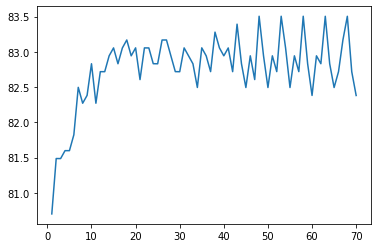

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [13]:
model = XGBClassifier(n_estimators=1825,learning_rate=0.005,n_jobs=4,random_state=21)

pip = Pipeline(steps=[('model',model)])
pip.fit(X, y)
predic = pip.predict(X_test)


output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predic})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
